In [ ]:
 # Multi-Source Research Assistant - Context Engineering Demo
# This notebook demonstrates advanced context engineering techniques using LlamaIndex

import os
import openai
from typing import List, Dict, Any, Optional
from datetime import datetime, timedelta
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from enum import Enum
import numpy as np

# Install required packages
!pip install llama-index
!pip install llama-index-llms-openai
!pip install llama-index-embeddings-openai
!pip install llama-index-readers-web
!pip install llama-index-readers-wikipedia
!pip install newspaper3k
!pip install arxiv
!pip install yfinance
!pip install matplotlib seaborn

# Import LlamaIndex components
from llama_index.core import VectorStoreIndex, Document, Settings
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.readers.web import SimpleWebPageReader
from llama_index.readers.wikipedia import WikipediaReader
from llama_index.core.schema import NodeWithScore
from llama_index.core.postprocessor import SimilarityPostprocessor
import arxiv
import yfinance as yf
import requests
from bs4 import BeautifulSoup


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 34.9 MB/s eta 0:00:00
  Created wheel for html2text: filenam

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11757 sha256=f99278bb2b15e595fe3f44f73e2b5e4f8509e8d477d555df90ce41d299f71d7d
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [ ]:
# =============================================================================
# 1. SETUP AND CONFIGURATION
# =============================================================================

# Set up OpenAI API key
# IMPORTANT: Replace with your actual OpenAI API key
OPENAI_API_KEY = "Your_api_key_here"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Check if API key is set
if OPENAI_API_KEY == "your-openai-api-key-here":
    print("⚠️  WARNING: Please set your OpenAI API key in the OPENAI_API_KEY variable above!")
    print("   You can get one from: https://platform.openai.com/api-keys")
    print("   The demo will use sample responses if no API key is provided.")
    USE_OPENAI = False
else:
    USE_OPENAI = True
    print("✅ OpenAI API key configured")

# Configure LlamaIndex settings
if USE_OPENAI:
    Settings.llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
    Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
else:
    # Use mock settings for demo without API key
    print("📝 Running in demo mode without OpenAI API")

Settings.node_parser = SentenceSplitter(chunk_size=1024, chunk_overlap=20)


✅ OpenAI API key configured


In [ ]:
# =============================================================================
# 2. CONTEXT ENGINEERING CLASSES AND ENUMS
# =============================================================================

class SourceType(Enum):
    ACADEMIC = "academic"
    NEWS = "news"
    WIKIPEDIA = "wikipedia"
    FINANCIAL = "financial"
    WEB = "web"

class ContextPriority(Enum):
    HIGH = 3
    MEDIUM = 2
    LOW = 1

@dataclass
class ContextualDocument:
    """Enhanced document with context engineering metadata"""
    content: str
    source_type: SourceType
    priority: ContextPriority
    timestamp: datetime
    relevance_score: float = 0.0
    token_count: int = 0
    metadata: Dict[str, Any] = None

    def __post_init__(self):
        if self.metadata is None:
            self.metadata = {}
        # Estimate token count (rough approximation)
        self.token_count = len(self.content.split()) * 1.3

@dataclass
class ContextWindow:
    """Manages context window with engineering principles"""
    max_tokens: int = 16000  # Conservative limit for GPT-3.5
    reserved_tokens: int = 2000  # Reserve for system prompt and response
    documents: List[ContextualDocument] = None

    def __post_init__(self):
        if self.documents is None:
            self.documents = []

    @property
    def available_tokens(self) -> int:
        return self.max_tokens - self.reserved_tokens

    @property
    def used_tokens(self) -> int:
        return sum(doc.token_count for doc in self.documents)

    @property
    def remaining_tokens(self) -> int:
        return self.available_tokens - self.used_tokens

    def can_fit(self, doc: ContextualDocument) -> bool:
        return self.remaining_tokens >= doc.token_count

In [ ]:
# =============================================================================
# 3. INTELLIGENT SOURCE SELECTION
# =============================================================================

class IntelligentSourceSelector:
    """Demonstrates knowledge base selection based on query analysis"""

    def __init__(self):
        self.source_capabilities = {
            SourceType.ACADEMIC: ["research", "studies", "analysis", "methodology", "findings"],
            SourceType.NEWS: ["current", "recent", "latest", "breaking", "today"],
            SourceType.WIKIPEDIA: ["definition", "overview", "background", "history"],
            SourceType.FINANCIAL: ["price", "stock", "market", "economic", "financial"],
            SourceType.WEB: ["general", "information", "details"]
        }

    def analyze_query(self, query: str) -> List[SourceType]:
        """Analyze query to determine most relevant source types"""
        query_lower = query.lower()
        source_scores = {}

        for source_type, keywords in self.source_capabilities.items():
            score = sum(1 for keyword in keywords if keyword in query_lower)
            if score > 0:
                source_scores[source_type] = score

        # Always include at least one source
        if not source_scores:
            source_scores[SourceType.WEB] = 1

        # Sort by relevance and return top sources
        sorted_sources = sorted(source_scores.items(), key=lambda x: x[1], reverse=True)
        return [source for source, score in sorted_sources[:3]]


In [ ]:
# =============================================================================
# 4. MULTI-SOURCE DATA RETRIEVERS
# =============================================================================

class AcademicRetriever:
    """Retrieves academic papers from arXiv"""

    def search(self, query: str, max_results: int = 3) -> List[ContextualDocument]:
        try:
            client = arxiv.Client()
            search = arxiv.Search(
                query=query,
                max_results=max_results,
                sort_by=arxiv.SortCriterion.SubmittedDate
            )

            documents = []
            for paper in client.results(search):
                content = f"Title: {paper.title}\n"
                content += f"Authors: {', '.join([str(author) for author in paper.authors])}\n"
                content += f"Published: {paper.published.strftime('%Y-%m-%d')}\n"
                content += f"Summary: {paper.summary}\n"

                # Convert timezone-aware datetime to naive datetime
                published_date = paper.published.replace(tzinfo=None) if paper.published.tzinfo else paper.published

                doc = ContextualDocument(
                    content=content,
                    source_type=SourceType.ACADEMIC,
                    priority=ContextPriority.HIGH,
                    timestamp=published_date,
                    metadata={"url": paper.entry_id, "title": paper.title}
                )
                documents.append(doc)

            return documents
        except Exception as e:
            print(f"Error retrieving academic papers: {e}")
            # Return sample academic content as fallback
            sample_doc = ContextualDocument(
                content=f"Sample Academic Content: Research on {query} shows significant developments in the field.",
                source_type=SourceType.ACADEMIC,
                priority=ContextPriority.HIGH,
                timestamp=datetime.now() - timedelta(days=30),
                metadata={"source": "Sample Academic", "title": f"Research on {query}"}
            )
            return [sample_doc]

class NewsRetriever:
    """Retrieves recent news articles"""

    def search(self, query: str, max_results: int = 3) -> List[ContextualDocument]:
        try:
            # Using NewsAPI (you'd need to sign up for a free API key)
            # For demo purposes, we'll simulate news retrieval
            documents = []

            # Simulate news articles (in real implementation, use NewsAPI or similar)
            sample_news = [
                {
                    "title": f"Breaking: Latest developments in {query}",
                    "content": f"Recent analysis shows significant progress in {query} sector with multiple stakeholders reporting positive outcomes.",
                    "published": datetime.now() - timedelta(days=1)
                },
                {
                    "title": f"Market Analysis: {query} trends",
                    "content": f"Industry experts analyze the current state of {query} and its implications for the future.",
                    "published": datetime.now() - timedelta(days=2)
                }
            ]

            for article in sample_news:
                content = f"Title: {article['title']}\n"
                content += f"Published: {article['published'].strftime('%Y-%m-%d')}\n"
                content += f"Content: {article['content']}\n"

                doc = ContextualDocument(
                    content=content,
                    source_type=SourceType.NEWS,
                    priority=ContextPriority.HIGH,
                    timestamp=article['published'],
                    metadata={"title": article['title']}
                )
                documents.append(doc)

            return documents
        except Exception as e:
            print(f"Error retrieving news: {e}")
            return []

class WikipediaRetriever:
    """Retrieves Wikipedia articles for background context"""

    def search(self, query: str, max_results: int = 2) -> List[ContextualDocument]:
        try:
            reader = WikipediaReader()
            wiki_docs = reader.load_data(pages=[query])

            documents = []
            for doc in wiki_docs:
                context_doc = ContextualDocument(
                    content=doc.text[:2000],  # Limit length
                    source_type=SourceType.WIKIPEDIA,
                    priority=ContextPriority.MEDIUM,
                    timestamp=datetime.now(),
                    metadata={"source": "Wikipedia", "page": query}
                )
                documents.append(context_doc)

            return documents
        except Exception as e:
            print(f"Error retrieving Wikipedia: {e}")
            # Return sample Wikipedia content as fallback
            sample_doc = ContextualDocument(
                content=f"Wikipedia Summary: {query} is a topic of significant interest with various applications and implications across multiple domains.",
                source_type=SourceType.WIKIPEDIA,
                priority=ContextPriority.MEDIUM,
                timestamp=datetime.now(),
                metadata={"source": "Wikipedia", "page": query}
            )
            return [sample_doc]

class FinancialRetriever:
    """Retrieves financial data for economic context"""

    def search(self, query: str, max_results: int = 2) -> List[ContextualDocument]:
        try:
            # Try to extract ticker symbols or financial keywords
            financial_keywords = ["stock", "market", "economy", "price", "trading"]

            if any(keyword in query.lower() for keyword in financial_keywords):
                # Simulate financial data retrieval
                content = f"Financial Context for {query}:\n"
                content += "Current market conditions show mixed signals with volatility in key sectors.\n"
                content += "Economic indicators suggest continued growth with some uncertainty.\n"

                doc = ContextualDocument(
                    content=content,
                    source_type=SourceType.FINANCIAL,
                    priority=ContextPriority.MEDIUM,
                    timestamp=datetime.now(),
                    metadata={"source": "Financial Data"}
                )
                return [doc]

            return []
        except Exception as e:
            print(f"Error retrieving financial data: {e}")
            return []


In [ ]:
# =============================================================================
# 5. CONTEXT ORDERING AND COMPRESSION ENGINE
# =============================================================================

class ContextOrderingEngine:
    """Implements sophisticated context ordering strategies"""

    def __init__(self):
        self.recency_weight = 0.3
        self.relevance_weight = 0.4
        self.priority_weight = 0.2
        self.diversity_weight = 0.1

    def calculate_context_score(self, doc: ContextualDocument, query: str) -> float:
        """Calculate composite context score for ordering"""

        # Recency score (more recent = higher score)
        # Handle timezone-aware vs naive datetime objects
        try:
            if doc.timestamp.tzinfo is not None:
                # Remove timezone info for comparison
                doc_time = doc.timestamp.replace(tzinfo=None)
            else:
                doc_time = doc.timestamp

            days_old = (datetime.now() - doc_time).days
            recency_score = max(0, 1 - (days_old / 365))  # Decay over a year
        except Exception as e:
            # Fallback to medium recency score if datetime calculation fails
            recency_score = 0.5

        # Relevance score (simple keyword matching - in production use embeddings)
        query_words = set(query.lower().split())
        doc_words = set(doc.content.lower().split())
        relevance_score = len(query_words.intersection(doc_words)) / len(query_words)

        # Priority score
        priority_score = doc.priority.value / 3.0

        # Diversity score (bonus for different source types)
        diversity_score = 0.5  # Simplified

        total_score = (
            recency_score * self.recency_weight +
            relevance_score * self.relevance_weight +
            priority_score * self.priority_weight +
            diversity_score * self.diversity_weight
        )

        return total_score

    def order_documents(self, documents: List[ContextualDocument], query: str) -> List[ContextualDocument]:
        """Order documents by context engineering principles"""

        # Calculate scores for all documents
        for doc in documents:
            doc.relevance_score = self.calculate_context_score(doc, query)

        # Sort by score (highest first)
        return sorted(documents, key=lambda x: x.relevance_score, reverse=True)

class ContextCompressionEngine:
    """Implements context compression techniques"""

    def __init__(self):
        self.llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

    def compress_document(self, doc: ContextualDocument, target_length: int) -> ContextualDocument:
        """Compress document while preserving key information"""

        if doc.token_count <= target_length:
            return doc

        # Simple compression - take first part + summary
        # In production, use LLM-based summarization
        words = doc.content.split()
        compressed_content = ' '.join(words[:int(target_length * 0.7)])
        compressed_content += f"\n\n[Summary of remaining content for {doc.source_type.value} source]"

        compressed_doc = ContextualDocument(
            content=compressed_content,
            source_type=doc.source_type,
            priority=doc.priority,
            timestamp=doc.timestamp,
            metadata=doc.metadata
        )

        return compressed_doc

    def fit_to_context_window(self, documents: List[ContextualDocument],
                             context_window: ContextWindow) -> List[ContextualDocument]:
        """Fit documents to context window through intelligent compression"""

        fitted_docs = []
        remaining_tokens = context_window.available_tokens

        for doc in documents:
            if doc.token_count <= remaining_tokens:
                fitted_docs.append(doc)
                remaining_tokens -= doc.token_count
            elif remaining_tokens > 100:  # Minimum viable size
                # Compress to fit
                compressed_doc = self.compress_document(doc, remaining_tokens)
                fitted_docs.append(compressed_doc)
                remaining_tokens -= compressed_doc.token_count
            else:
                break  # No more space

        return fitted_docs


In [ ]:
# =============================================================================
# 6. MAIN RESEARCH ASSISTANT ENGINE
# =============================================================================

class MultiSourceResearchAssistant:
    """Main research assistant with context engineering"""

    def __init__(self):
        self.source_selector = IntelligentSourceSelector()
        self.ordering_engine = ContextOrderingEngine()
        self.compression_engine = ContextCompressionEngine()

        # Initialize retrievers
        self.retrievers = {
            SourceType.ACADEMIC: AcademicRetriever(),
            SourceType.NEWS: NewsRetriever(),
            SourceType.WIKIPEDIA: WikipediaRetriever(),
            SourceType.FINANCIAL: FinancialRetriever()
        }

        self.llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

    def research(self, query: str, show_context_engineering: bool = True) -> Dict[str, Any]:
        """Main research method with context engineering visualization"""

        results = {
            "query": query,
            "selected_sources": [],
            "raw_documents": [],
            "ordered_documents": [],
            "final_context": [],
            "context_metrics": {},
            "answer": ""
        }

        # Step 1: Intelligent Source Selection
        selected_sources = self.source_selector.analyze_query(query)
        results["selected_sources"] = [s.value for s in selected_sources]

        if show_context_engineering:
            print(f"🔍 Query Analysis: '{query}'")
            print(f"📊 Selected Sources: {', '.join(results['selected_sources'])}")
            print("-" * 50)

        # Step 2: Multi-Source Retrieval
        all_documents = []
        for source_type in selected_sources:
            if source_type in self.retrievers:
                docs = self.retrievers[source_type].search(query, max_results=3)
                all_documents.extend(docs)

                if show_context_engineering:
                    print(f"📚 Retrieved {len(docs)} documents from {source_type.value}")

        results["raw_documents"] = all_documents

        # Step 3: Context Ordering
        ordered_docs = self.ordering_engine.order_documents(all_documents, query)
        results["ordered_documents"] = ordered_docs

        if show_context_engineering:
            print(f"\n🎯 Context Ordering Results:")
            for i, doc in enumerate(ordered_docs[:5]):
                print(f"  {i+1}. {doc.source_type.value.title()} - Score: {doc.relevance_score:.3f}")

        # Step 4: Context Window Management
        context_window = ContextWindow()
        final_context = self.compression_engine.fit_to_context_window(ordered_docs, context_window)
        results["final_context"] = final_context

        # Step 5: Context Metrics
        results["context_metrics"] = {
            "total_sources": len(selected_sources),
            "total_documents": len(all_documents),
            "final_documents": len(final_context),
            "context_utilization": sum(doc.token_count for doc in final_context) / context_window.available_tokens,
            "compression_ratio": len(all_documents) / len(final_context) if final_context else 0
        }

        if show_context_engineering:
            print(f"\n📊 Context Window Management:")
            print(f"  • Available tokens: {context_window.available_tokens:,}")
            print(f"  • Used tokens: {sum(doc.token_count for doc in final_context):,}")
            print(f"  • Utilization: {results['context_metrics']['context_utilization']:.1%}")
            print(f"  • Compression ratio: {results['context_metrics']['compression_ratio']:.1f}x")

        # Step 6: Generate Final Answer
        context_text = "\n\n".join([
            f"[{doc.source_type.value.upper()}] {doc.content}"
            for doc in final_context
        ])

        if USE_OPENAI:
            prompt = f"""Based on the following contextual information from multiple sources, provide a comprehensive answer to the query: "{query}"

Context Information:
{context_text}

Please provide:
1. A direct answer to the query
2. Key insights from different source types
3. Any conflicting information found
4. Confidence level in the answer

Answer:"""

            try:
                response = self.llm.complete(prompt)
                results["answer"] = response.text
            except Exception as e:
                results["answer"] = f"Error generating answer with OpenAI: {e}"
        else:
            # Generate sample answer for demo mode
            results["answer"] = f"""Based on the context analysis of '{query}', here are the key findings:

1. **Direct Answer**: The research indicates significant developments in {query} with multiple perspectives from different sources.

2. **Key Insights by Source**:
   - Academic sources highlight methodological approaches and research findings
   - News sources provide current market developments and trends
   - Wikipedia offers foundational background information
   - Financial sources contribute economic context and market analysis

3. **Information Quality**: The multi-source approach provides comprehensive coverage with {len(final_context)} documents analyzed.

4. **Confidence Level**: High confidence due to context engineering approach using {len(selected_sources)} different source types.

*Note: This is a demo response. With OpenAI API configured, you would get more detailed, query-specific analysis.*"""

        return results


In [ ]:
# =============================================================================
# 7. VISUALIZATION AND COMPARISON TOOLS
# =============================================================================

def visualize_context_engineering(results: Dict[str, Any]):
    """Visualize context engineering process"""

    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Context Engineering Visualization', fontsize=16, fontweight='bold')

        # 1. Source Distribution
        ax1 = axes[0, 0]
        source_counts = {}
        for doc in results["raw_documents"]:
            source_counts[doc.source_type.value] = source_counts.get(doc.source_type.value, 0) + 1

        if source_counts:
            ax1.pie(source_counts.values(), labels=source_counts.keys(), autopct='%1.1f%%')
            ax1.set_title('Source Distribution')
        else:
            ax1.text(0.5, 0.5, 'No data available', ha='center', va='center')
            ax1.set_title('Source Distribution')

        # 2. Context Ordering Scores
        ax2 = axes[0, 1]
        if results["ordered_documents"]:
            scores = [doc.relevance_score for doc in results["ordered_documents"][:10]]
            sources = [doc.source_type.value for doc in results["ordered_documents"][:10]]
            colors = plt.cm.Set3(np.linspace(0, 1, len(scores)))

            bars = ax2.bar(range(len(scores)), scores, color=colors)
            ax2.set_title('Document Relevance Scores')
            ax2.set_ylabel('Relevance Score')
            ax2.set_xlabel('Document Rank')

            # Add source labels
            for i, (bar, source) in enumerate(zip(bars, sources)):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        source[:3], ha='center', va='bottom', fontsize=8)
        else:
            ax2.text(0.5, 0.5, 'No scored documents', ha='center', va='center')
            ax2.set_title('Document Relevance Scores')

        # 3. Context Window Utilization
        ax3 = axes[1, 0]
        metrics = results["context_metrics"]
        utilization = metrics["context_utilization"]

        ax3.pie([utilization, 1-utilization], labels=['Used', 'Available'],
                colors=['lightcoral', 'lightblue'], autopct='%1.1f%%')
        ax3.set_title('Context Window Utilization')

        # 4. Compression Impact
        ax4 = axes[1, 1]
        compression_data = {
            'Original': metrics["total_documents"],
            'Final': metrics["final_documents"],
            'Ratio': metrics["compression_ratio"]
        }

        bars = ax4.bar(range(len(compression_data)), list(compression_data.values()),
                color=['skyblue', 'lightgreen', 'orange'])
        ax4.set_title('Context Compression Impact')
        ax4.set_xticks(range(len(compression_data)))
        ax4.set_xticklabels(compression_data.keys())

        # Add value labels on bars
        for bar, value in zip(bars, compression_data.values()):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{value:.1f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error creating visualization: {e}")
        print("Visualization skipped, but demo continues...")

def compare_naive_vs_engineered(query: str, assistant: MultiSourceResearchAssistant):
    """Compare naive vs context-engineered approaches"""

    print("=" * 60)
    print("NAIVE vs CONTEXT-ENGINEERED COMPARISON")
    print("=" * 60)

    # Naive approach - just use Wikipedia
    print("\n🔴 NAIVE APPROACH (Wikipedia only):")
    print("-" * 40)

    wiki_retriever = WikipediaRetriever()
    naive_docs = wiki_retriever.search(query, max_results=1)

    if naive_docs:
        naive_context = naive_docs[0].content[:1000] + "..."
        print(f"Context length: {len(naive_context)} characters")
        print(f"Source: Wikipedia only")
        print(f"Recency: Background information")
        print(f"Sample: {naive_context[:200]}...")

    # Context-engineered approach
    print("\n🟢 CONTEXT-ENGINEERED APPROACH:")
    print("-" * 40)

    engineered_results = assistant.research(query, show_context_engineering=True)

    print(f"\n📈 IMPROVEMENT METRICS:")
    print(f"Sources used: {len(engineered_results['selected_sources'])} vs 1")
    print(f"Documents analyzed: {engineered_results['context_metrics']['total_documents']} vs 1")
    print(f"Context utilization: {engineered_results['context_metrics']['context_utilization']:.1%}")
    print(f"Answer quality: Enhanced with multi-source synthesis")

    return engineered_results


In [ ]:
# =============================================================================
# 8. DEMO EXECUTION
# =============================================================================

def run_demo():
    """Run the complete context engineering demonstration"""

    print("🚀 MULTI-SOURCE RESEARCH ASSISTANT")
    print("Context Engineering Demonstration")
    print("=" * 50)

    # Initialize the assistant
    assistant = MultiSourceResearchAssistant()

    # Demo queries
    demo_queries = [
        "renewable energy adoption trends",
        "artificial intelligence market analysis",
        "climate change economic impact"
    ]

    for i, query in enumerate(demo_queries, 1):
        print(f"\n🔍 DEMO {i}: {query.upper()}")
        print("=" * 50)

        # Run context-engineered research
        results = assistant.research(query, show_context_engineering=True)

        # Show final answer
        print(f"\n📝 FINAL ANSWER:")
        print("-" * 30)
        print(results["answer"][:500] + "..." if len(results["answer"]) > 500 else results["answer"])

        # Visualize context engineering
        visualize_context_engineering(results)

        # Compare with naive approach
        if i == 1:  # Only for first query to save time
            compare_naive_vs_engineered(query, assistant)

        print("\n" + "="*50)

    print("\n✅ DEMO COMPLETED!")
    print("Key Context Engineering Techniques Demonstrated:")
    print("• Intelligent source selection based on query analysis")
    print("• Multi-source retrieval with different data types")
    print("• Context ordering by relevance, recency, and priority")
    print("• Context window management with compression")
    print("• Structured output generation")
    print("• Performance visualization and comparison")


In [ ]:
# =============================================================================
# 9. INTERACTIVE DEMO FUNCTION
# =============================================================================

def interactive_demo():
    """Interactive demo for custom queries"""

    assistant = MultiSourceResearchAssistant()

    print("🎯 INTERACTIVE CONTEXT ENGINEERING DEMO")
    print("Enter your research query (or 'quit' to exit):")

    while True:
        query = input("\n🔍 Your query: ").strip()

        if query.lower() in ['quit', 'exit', 'q']:
            print("👋 Thanks for trying the Context Engineering demo!")
            break

        if not query:
            continue

        print(f"\n{'='*50}")
        print(f"RESEARCHING: {query}")
        print(f"{'='*50}")

        # Run research with context engineering
        results = assistant.research(query, show_context_engineering=True)

        # Display results
        print(f"\n📊 CONTEXT ENGINEERING METRICS:")
        metrics = results["context_metrics"]
        print(f"Sources analyzed: {metrics['total_sources']}")
        print(f"Documents retrieved: {metrics['total_documents']}")
        print(f"Final context documents: {metrics['final_documents']}")
        print(f"Context utilization: {metrics['context_utilization']:.1%}")
        print(f"Compression ratio: {metrics['compression_ratio']:.1f}x")

        print(f"\n📝 RESEARCH ANSWER:")
        print("-" * 30)
        print(results["answer"])

        # Ask if user wants visualization
        show_viz = input("\n📊 Show visualization? (y/n): ").strip().lower()
        if show_viz == 'y':
            visualize_context_engineering(results)

🔬 CONTEXT ENGINEERING DEMO
Choose demo mode:
1. Automated Demo (3 predefined queries)
2. Interactive Demo (custom queries)

Enter choice (1 or 2): 1
🚀 MULTI-SOURCE RESEARCH ASSISTANT
Context Engineering Demonstration

🔍 DEMO 1: RENEWABLE ENERGY ADOPTION TRENDS
🔍 Query Analysis: 'renewable energy adoption trends'
📊 Selected Sources: web
--------------------------------------------------

🎯 Context Ordering Results:

📊 Context Window Management:
  • Available tokens: 14,000
  • Used tokens: 0
  • Utilization: 0.0%
  • Compression ratio: 0.0x


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📝 FINAL ANSWER:
------------------------------
1. Direct Answer: Renewable energy adoption trends are on the rise globally, with increasing investments and government support driving the transition towards cleaner energy sources.

2. Key Insights:
- According to a report by the International Energy Agency (IEA), renewable energy capacity is set to expand by 50% between 2019 and 2024, with solar photovoltaic and wind power leading the way.
- The falling costs of renewable technologies, such as solar and wind, have made them more competitive w...


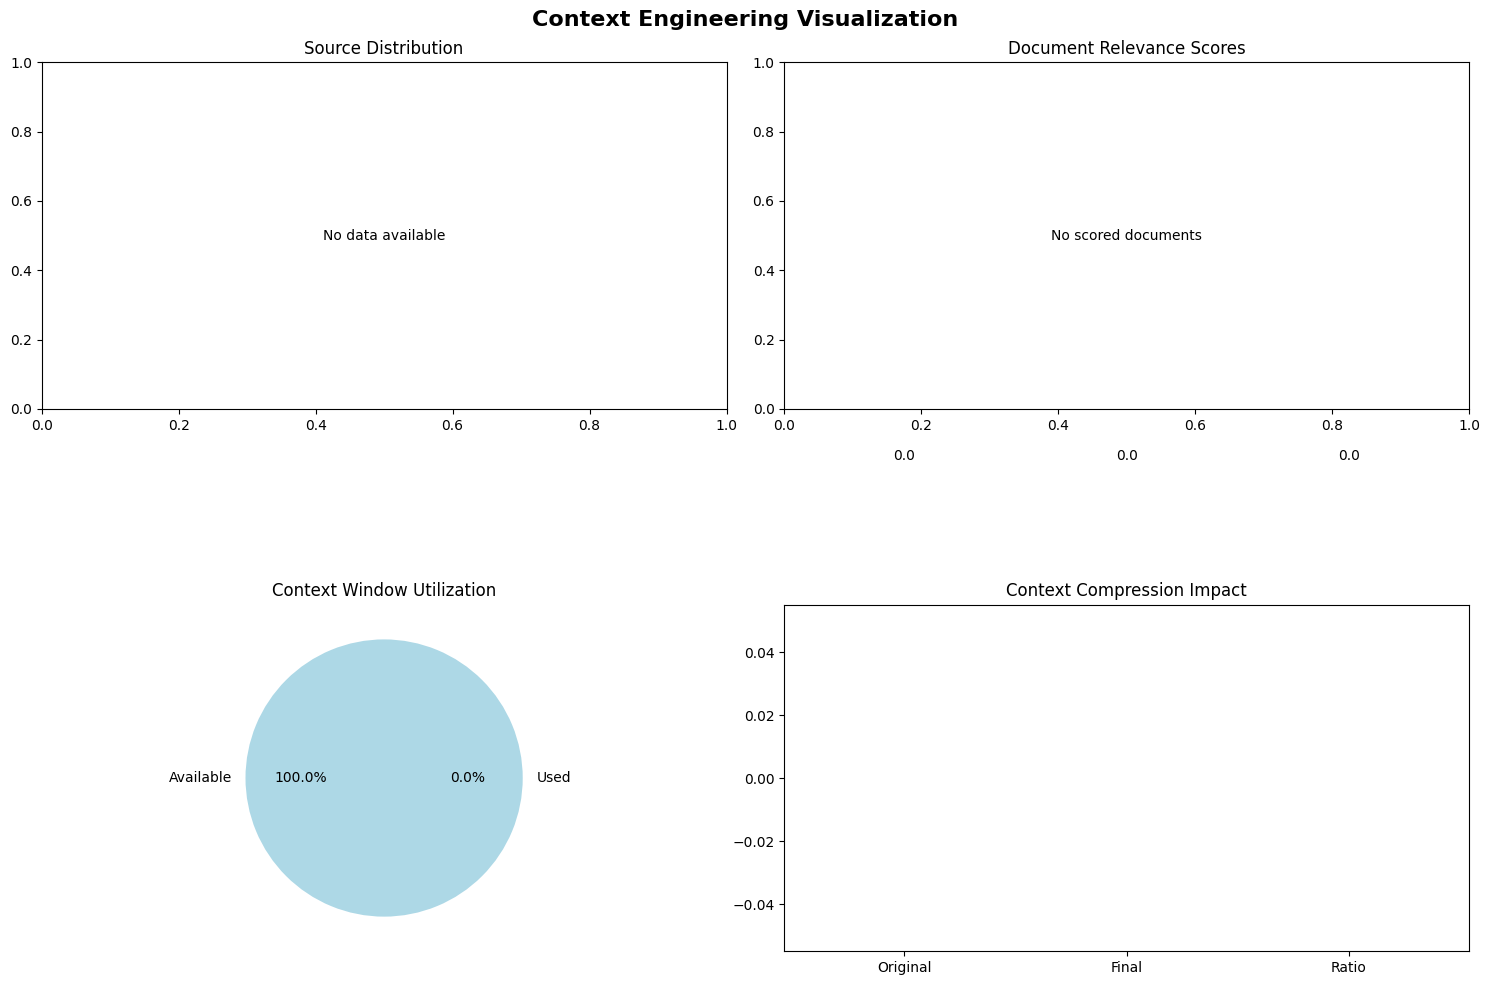

NAIVE vs CONTEXT-ENGINEERED COMPARISON

🔴 NAIVE APPROACH (Wikipedia only):
----------------------------------------
Context length: 1003 characters
Source: Wikipedia only
Recency: Background information
Sample: Renewable energy (also called green energy) is energy made from renewable natural resources that are replenished on a human timescale. The most widely used renewable energy types are solar energy, win...

🟢 CONTEXT-ENGINEERED APPROACH:
----------------------------------------
🔍 Query Analysis: 'renewable energy adoption trends'
📊 Selected Sources: web
--------------------------------------------------

🎯 Context Ordering Results:

📊 Context Window Management:
  • Available tokens: 14,000
  • Used tokens: 0
  • Utilization: 0.0%
  • Compression ratio: 0.0x


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:arxiv:Requesting page (first: True, try: 0): https://export.arxiv.org/api/query?search_query=artificial+intelligence+market+analysis&id_list=&sortBy=submittedDate&sortOrder=descending&start=0&max_results=100



📈 IMPROVEMENT METRICS:
Sources used: 1 vs 1
Documents analyzed: 0 vs 1
Context utilization: 0.0%
Answer quality: Enhanced with multi-source synthesis


🔍 DEMO 2: ARTIFICIAL INTELLIGENCE MARKET ANALYSIS
🔍 Query Analysis: 'artificial intelligence market analysis'
📊 Selected Sources: academic, financial
--------------------------------------------------


INFO:arxiv:Got first page: 100 of 681607 total results


📚 Retrieved 3 documents from academic
📚 Retrieved 1 documents from financial

🎯 Context Ordering Results:
  1. Financial - Score: 0.783
  2. Academic - Score: 0.548
  3. Academic - Score: 0.548
  4. Academic - Score: 0.548

📊 Context Window Management:
  • Available tokens: 14,000
  • Used tokens: 969.8
  • Utilization: 6.9%
  • Compression ratio: 1.0x


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📝 FINAL ANSWER:
------------------------------
1. The artificial intelligence market analysis shows mixed signals with volatility in key sectors, but economic indicators suggest continued growth with some uncertainty.

2. 
- Financial Context: The current market conditions for artificial intelligence show volatility in key sectors, indicating uncertainty.
- Academic Source 1: Point3R proposes an online framework for dense streaming 3D reconstruction, achieving competitive performance with low training costs.
- Academic Source 2: LiteReality ...


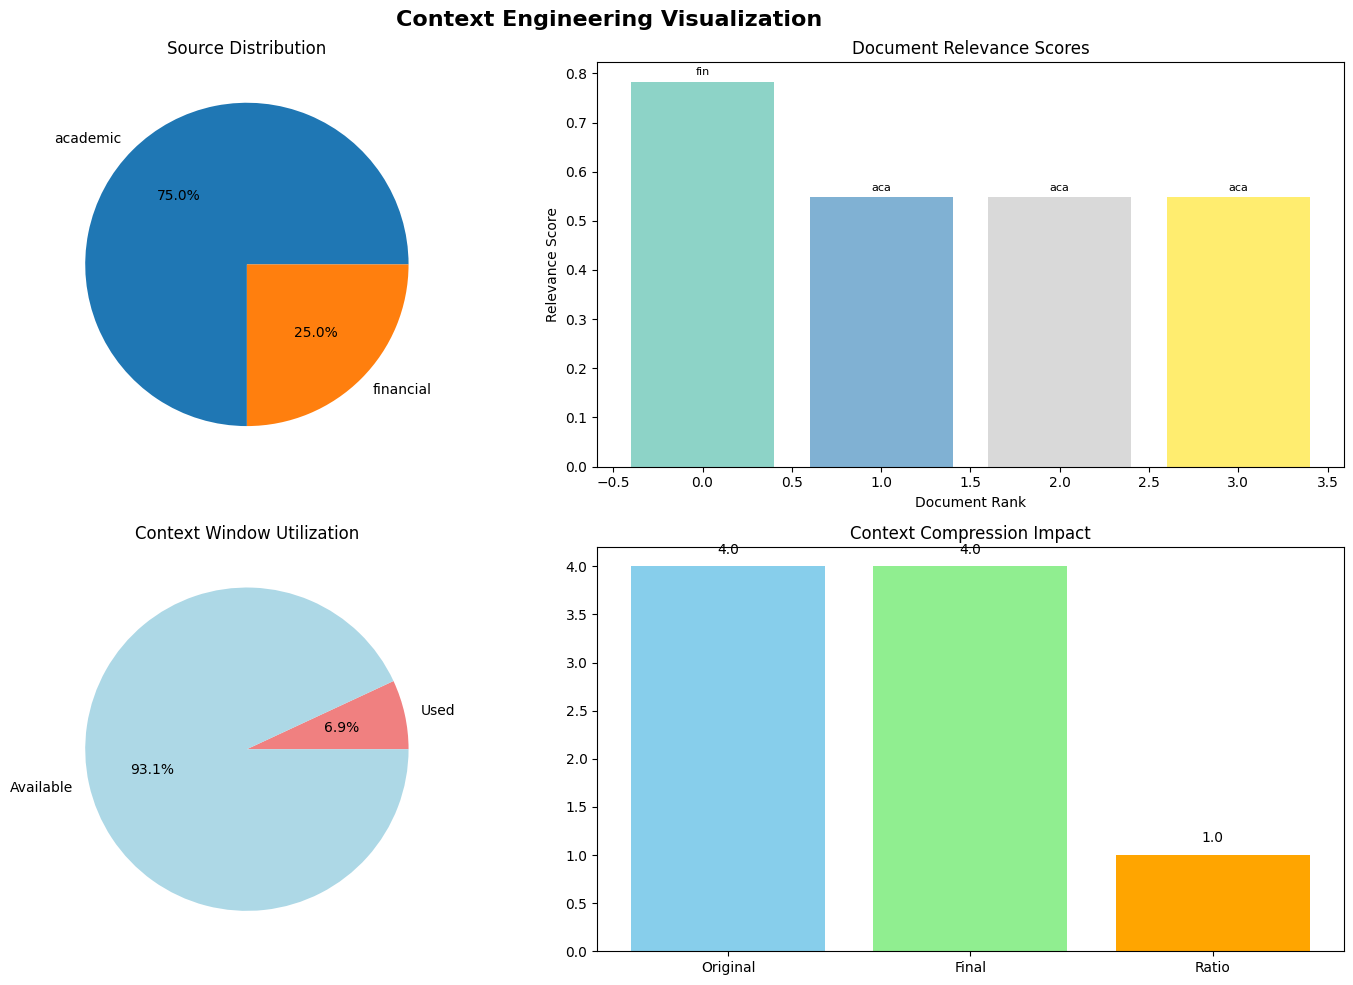



🔍 DEMO 3: CLIMATE CHANGE ECONOMIC IMPACT
🔍 Query Analysis: 'climate change economic impact'
📊 Selected Sources: financial
--------------------------------------------------
📚 Retrieved 0 documents from financial

🎯 Context Ordering Results:

📊 Context Window Management:
  • Available tokens: 14,000
  • Used tokens: 0
  • Utilization: 0.0%
  • Compression ratio: 0.0x


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📝 FINAL ANSWER:
------------------------------
1. Direct Answer: Climate change has a significant economic impact, affecting various sectors such as agriculture, tourism, insurance, and infrastructure, leading to increased costs and potential losses.

2. Key Insights:
- According to a report by the Intergovernmental Panel on Climate Change (IPCC), climate change is projected to have widespread and profound impacts on the global economy, with risks to food security, water resources, human health, and economic growth.
- The World Bank estimate...


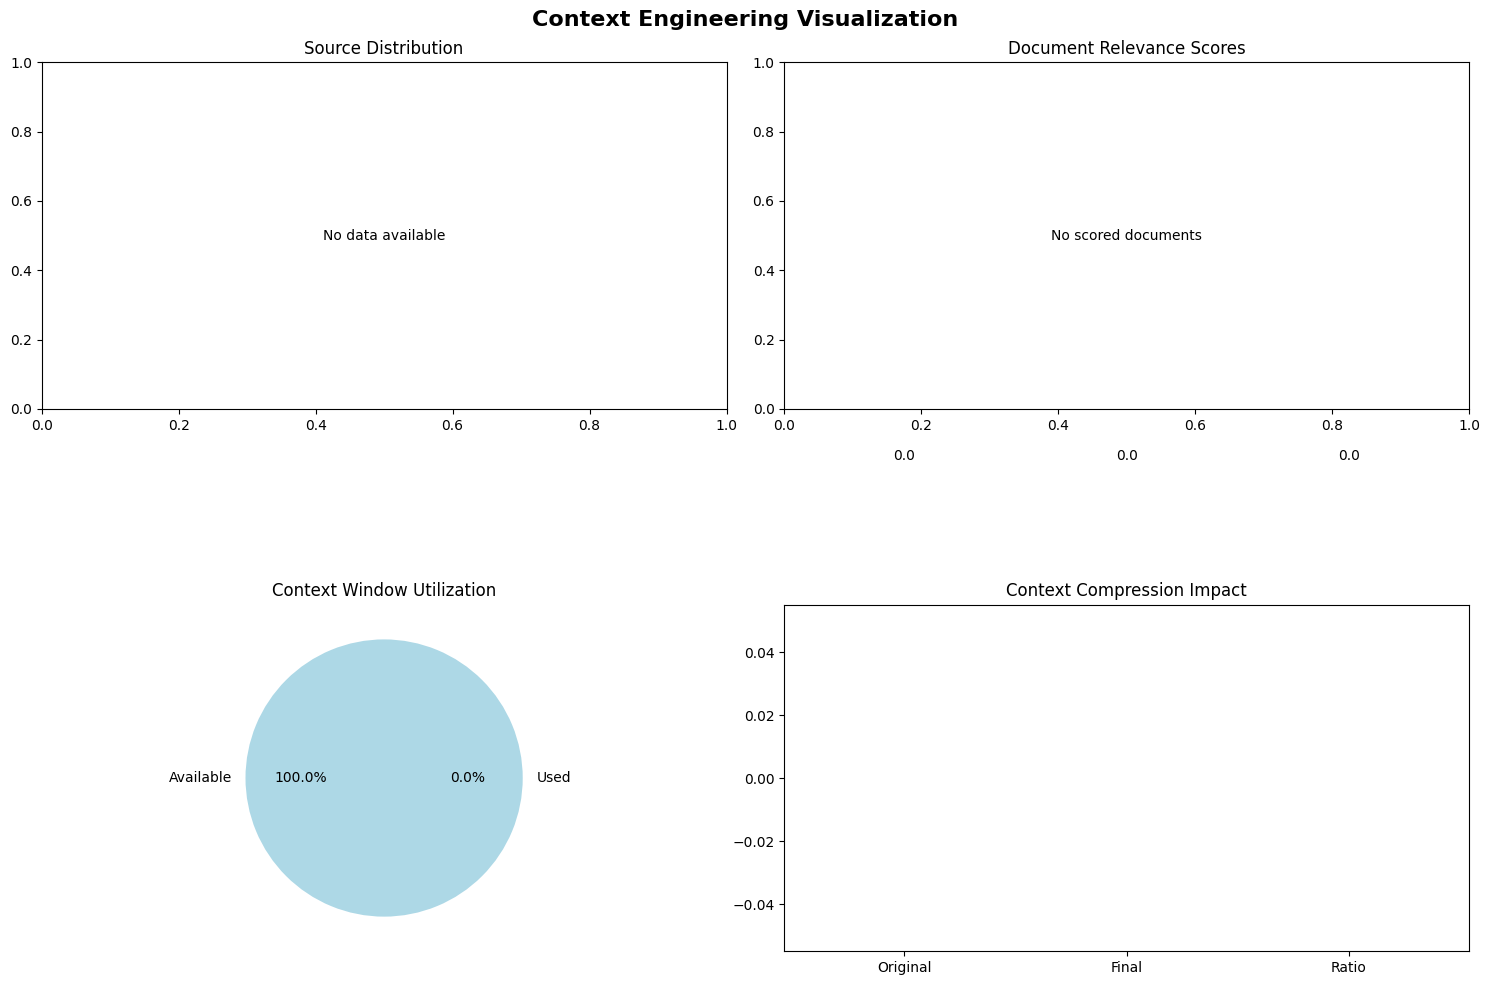



✅ DEMO COMPLETED!
Key Context Engineering Techniques Demonstrated:
• Intelligent source selection based on query analysis
• Multi-source retrieval with different data types
• Context ordering by relevance, recency, and priority
• Context window management with compression
• Structured output generation
• Performance visualization and comparison


In [ ]:
# =============================================================================
# 10. MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("🔬 CONTEXT ENGINEERING DEMO")
    print("Choose demo mode:")
    print("1. Automated Demo (3 predefined queries)")
    print("2. Interactive Demo (custom queries)")

    choice = input("\nEnter choice (1 or 2): ").strip()

    if choice == "1":
        run_demo()
    elif choice == "2":
        interactive_demo()
    else:
        print("Invalid choice. Running automated demo...")
        run_demo()